<a href="https://colab.research.google.com/github/johnsonadam187/scikit_ml_projects/blob/main/classification_of_heart_disease_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pwd


/content


In [5]:
%cd gdrive/MyDrive/"ML Datasets"/"UCI datasets"


/content/gdrive/MyDrive/ML Datasets/UCI datasets


In [6]:
df1 = pd.read_csv(r"/content/gdrive/MyDrive/ML Datasets/UCI datasets/Heart disease/processed.cleveland.data", header=None)
df1.columns = ["age", "sex", "chest_pain", "resting_blood_pressure", 
               "cholesterol", "fasting_blood_sugar", "resting_electrocardiographic_results", 
               "maximum_HR_achieved", "exercise_induced_angina", "ST_depression_by_exercise", 
               "slope_of_ST_exercise_peak", "major_vessels_coloured_by_fluoro", 
               "thallium_heart_scan", "diagnosis_of_heart_disease"]
df1.head()

,age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,maximum_HR_achieved,exercise_induced_angina,ST_depression_by_exercise,slope_of_ST_exercise_peak,major_vessels_coloured_by_fluoro,thallium_heart_scan,diagnosis_of_heart_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Examine the dataframe

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   303 non-null    float64
 1   sex                                   303 non-null    float64
 2   chest_pain                            303 non-null    float64
 3   resting_blood_pressure                303 non-null    float64
 4   cholesterol                           303 non-null    float64
 5   fasting_blood_sugar                   303 non-null    float64
 6   resting_electrocardiographic_results  303 non-null    float64
 7   maximum_HR_achieved                   303 non-null    float64
 8   exercise_induced_angina               303 non-null    float64
 9   ST_depression_by_exercise             303 non-null    float64
 10  slope_of_ST_exercise_peak             303 non-null    float64
 11  major_vessels_colou

In [8]:
df1["thallium_heart_scan"].value_counts()

3.0    166
7.0    117
6.0     18
?        2
Name: thallium_heart_scan, dtype: int64

In [9]:
df1['major_vessels_coloured_by_fluoro'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: major_vessels_coloured_by_fluoro, dtype: int64

Median is more valuable for filling these columns as they seem to be int values, only saved as float values. We would usually use imputer, however the columns are object type (string) so we can not directly replace the missing values. Also there are several 0 values that are real and we don't want to incorrectly change those, so we must use .replace to change the "?" values into numbers that can then be cast into float, using pd.astype().dtype. But first we must figure out the median of the column values that aren't "?".

In [10]:
thal_med = np.median([float(item) for item in df1['thallium_heart_scan'] if not item == "?"])
fluoro_med = np.median([float(item) for item in df1['major_vessels_coloured_by_fluoro'] if not item == "?"])
df1["thallium_heart_scan"].replace("?", thal_med, inplace=True)
df1['major_vessels_coloured_by_fluoro'].replace("?", fluoro_med, inplace=True)
df1.astype({"thallium_heart_scan":'float64', "major_vessels_coloured_by_fluoro":"float64"}).dtypes

age                                     float64
sex                                     float64
chest_pain                              float64
resting_blood_pressure                  float64
cholesterol                             float64
fasting_blood_sugar                     float64
resting_electrocardiographic_results    float64
maximum_HR_achieved                     float64
exercise_induced_angina                 float64
ST_depression_by_exercise               float64
slope_of_ST_exercise_peak               float64
major_vessels_coloured_by_fluoro        float64
thallium_heart_scan                     float64
diagnosis_of_heart_disease                int64
dtype: object

Lets use describe to check the data further

In [11]:
df1.describe()

,age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,maximum_HR_achieved,exercise_induced_angina,ST_depression_by_exercise,slope_of_ST_exercise_peak,diagnosis_of_heart_disease
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


So it looks like the majority of the data is categorical with the exception of ['age', resting_blood_pressure', 'cholesterol', 'maximum_HR_achieved']. We will visualise these against 'diagnosis of heart disease' which is the target value for this dataset.

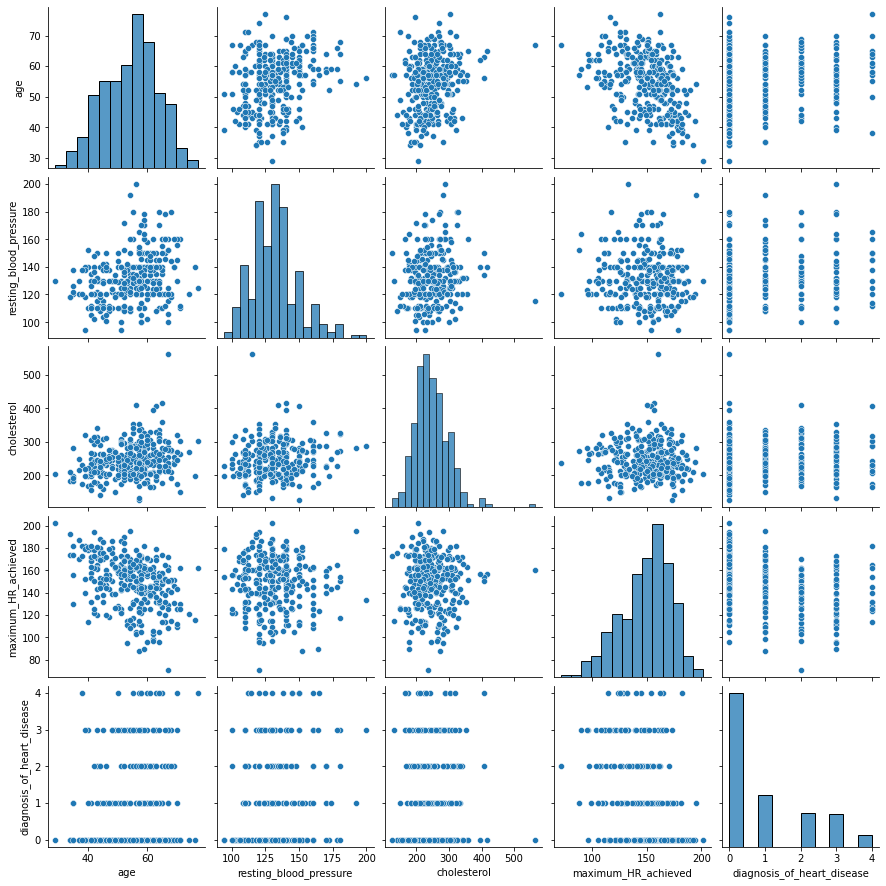

In [12]:
sns.pairplot(df1[['age', 'resting_blood_pressure', 'cholesterol', 'maximum_HR_achieved', 'diagnosis_of_heart_disease']])
plt.show()

So no clear linear correlations. Let's check the correaltion matrix (pearsons correlation value)

In [13]:
correlations = df1.corr()
correlations

,age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,maximum_HR_achieved,exercise_induced_angina,ST_depression_by_exercise,slope_of_ST_exercise_peak,diagnosis_of_heart_disease
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.222853
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.224469
chest_pain,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.407075
resting_blood_pressure,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.157754
cholesterol,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.070909
fasting_blood_sugar,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.059186
resting_electrocardiographic_results,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.183696
maximum_HR_achieved,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.415040
exercise_induced_angina,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.397057
ST_depression_by_exercise,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.504092


So the leading correlations to diagnosis of heart disease are age (22%) sex (22%), chest pain (40%) and other metrics associated with exercise induced angina or ST depression caused by exercise (up to 50%). Lets look at the data in the other columns as well.

In [14]:
for index, item in enumerate(df1.columns):
  print(f"{item}: {len(df1.iloc[:, index].value_counts())}")

age: 41
sex: 2
chest_pain: 4
resting_blood_pressure: 50
cholesterol: 152
fasting_blood_sugar: 2
resting_electrocardiographic_results: 3
maximum_HR_achieved: 91
exercise_induced_angina: 2
ST_depression_by_exercise: 40
slope_of_ST_exercise_peak: 3
major_vessels_coloured_by_fluoro: 5
thallium_heart_scan: 4
diagnosis_of_heart_disease: 5


This suggests that the majority of the columns are categorical. Which means we are looking at a classification problem, most likely. Lets split the feature and target data.


In [15]:
target = df1.pop("diagnosis_of_heart_disease")

So having categorical data numerically encoded is problematic sometimes as analyses will treat the different categories as they are continuous values in the column's dimensional space. So we can one hot encode the columns. Since sex, fasting blood sugar, and exercise induced angina, only contain two categories each, they are already encoded. So we can leave them as is. But we will cast them as integer values.

In [16]:
df2 = pd.get_dummies(data=df1, columns=['chest_pain', "resting_electrocardiographic_results", "slope_of_ST_exercise_peak", "major_vessels_coloured_by_fluoro", "thallium_heart_scan"])
df2 = df2.astype({'age':'int', 'sex':'int', 'fasting_blood_sugar':'int', 'exercise_induced_angina':'int'})
df2

,age,sex,resting_blood_pressure,cholesterol,fasting_blood_sugar,maximum_HR_achieved,exercise_induced_angina,ST_depression_by_exercise,chest_pain_1.0,chest_pain_2.0,chest_pain_3.0,chest_pain_4.0,resting_electrocardiographic_results_0.0,resting_electrocardiographic_results_1.0,resting_electrocardiographic_results_2.0,slope_of_ST_exercise_peak_1.0,slope_of_ST_exercise_peak_2.0,slope_of_ST_exercise_peak_3.0,major_vessels_coloured_by_fluoro_0.0,major_vessels_coloured_by_fluoro_0.0,major_vessels_coloured_by_fluoro_1.0,major_vessels_coloured_by_fluoro_2.0,major_vessels_coloured_by_fluoro_3.0,thallium_heart_scan_3.0,thallium_heart_scan_3.0,thallium_heart_scan_6.0,thallium_heart_scan_7.0
0,63,1,145.0,233.0,1,150.0,0,2.3,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0
1,67,1,160.0,286.0,0,108.0,1,1.5,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
2,67,1,120.0,229.0,0,129.0,1,2.6,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
3,37,1,130.0,250.0,0,187.0,0,3.5,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
4,41,0,130.0,204.0,0,172.0,0,1.4,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,110.0,264.0,0,132.0,0,1.2,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1
299,68,1,144.0,193.0,1,141.0,0,3.4,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
300,57,1,130.0,131.0,0,115.0,1,1.2,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1
301,57,0,130.0,236.0,0,174.0,0,0.0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0


In [17]:
df2.dtypes

age                                           int64
sex                                           int64
resting_blood_pressure                      float64
cholesterol                                 float64
fasting_blood_sugar                           int64
maximum_HR_achieved                         float64
exercise_induced_angina                       int64
ST_depression_by_exercise                   float64
chest_pain_1.0                                uint8
chest_pain_2.0                                uint8
chest_pain_3.0                                uint8
chest_pain_4.0                                uint8
resting_electrocardiographic_results_0.0      uint8
resting_electrocardiographic_results_1.0      uint8
resting_electrocardiographic_results_2.0      uint8
slope_of_ST_exercise_peak_1.0                 uint8
slope_of_ST_exercise_peak_2.0                 uint8
slope_of_ST_exercise_peak_3.0                 uint8
major_vessels_coloured_by_fluoro_0.0          uint8
major_vessel

Also when we think about what the target data is trying to say, we are trying to predict heart disease. So in some instances it might be useful to predict the degree of heart disease and give that a number, this changes the resulting analysis into a continuous prediction. However for our current purposes, we are only really looking obtaining the target of has heart disease vs does not have heart disease, which is a binary classification issue. For that reason we will change the target data into binary format where anything not 0, will then = 1.

In [21]:
target.unique()

array([0, 2, 1, 3, 4])

In [22]:
indices = target > 1
target[indices] = 1
target.unique()

array([0, 1])

Now we can split the data using train test split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df2, target, test_size=0.2, shuffle=True)

Instantiate the a model and fit the traiing data

In [25]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Display the tree

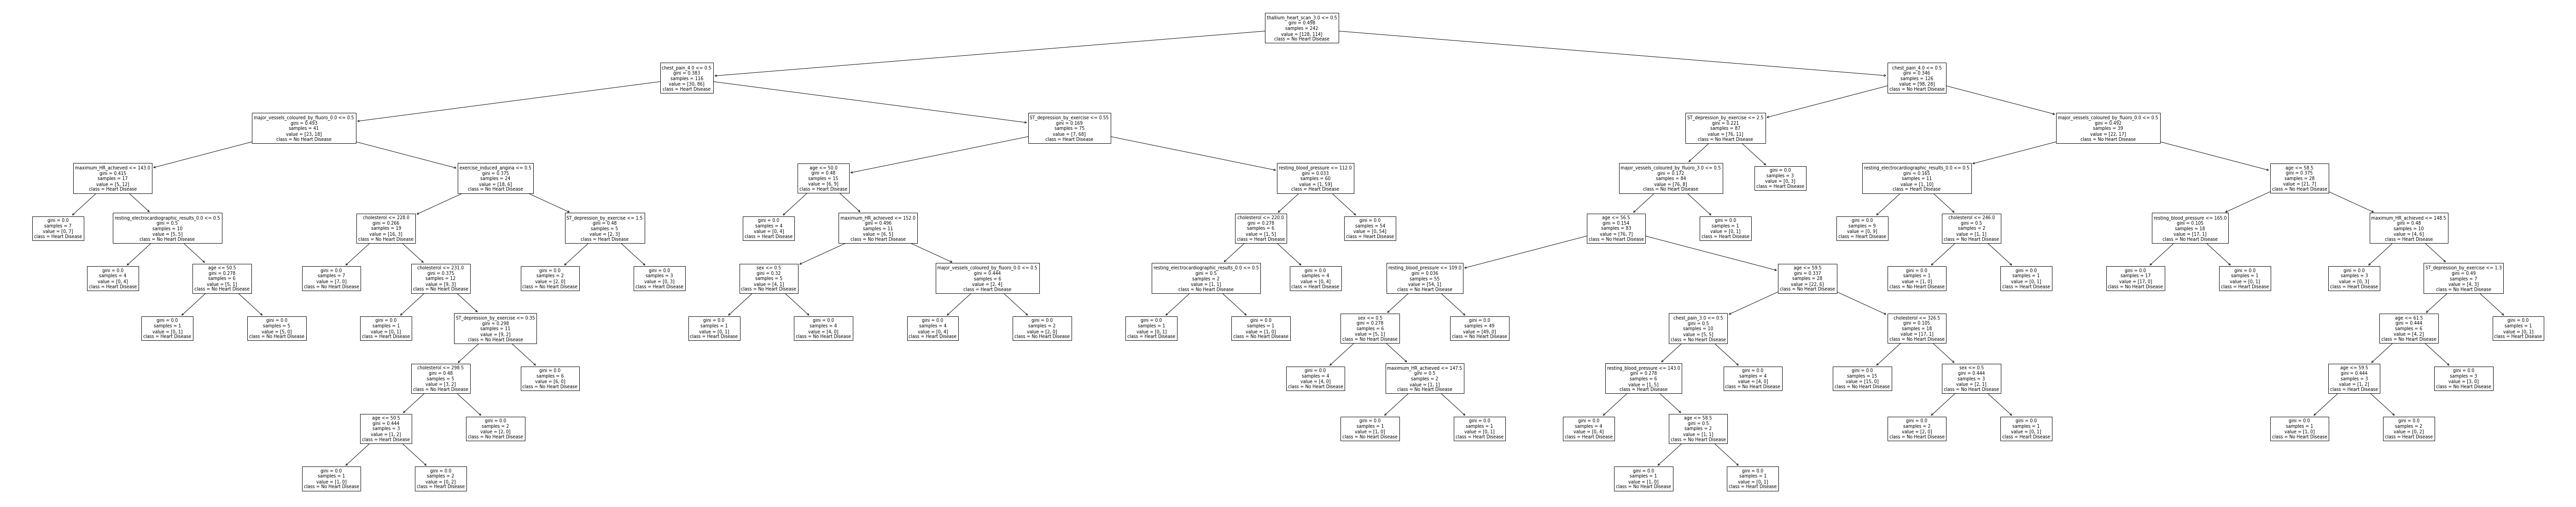

In [31]:
plt.figure(figsize=(100, 20))
plot_tree(tree, class_names=["No Heart Disease", "Heart Disease"], feature_names=df2.columns)
plt.show()

Now as always we want to test the model. We will use sklearns in built confusion_matrix function to display the results, by passing the model, and the testing data

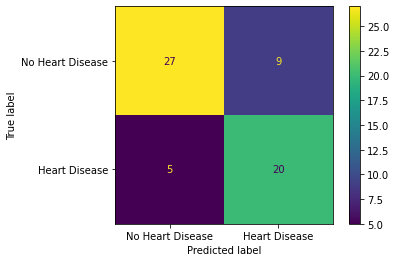

In [33]:
plot_confusion_matrix(tree, x_test, y_test, display_labels=["No Heart Disease", "Heart Disease"])
plt.show()

So what percentages are these?

In [35]:
number = len(y_test)
number

61

In [36]:
true_positives = 20
true_negatives = 27
false_positives = 9
false_negatives = 5

Now we calculate sensitivity and specificity. Sensitivity is a amount of people with the condition correctly predicted to have the condition (true positives), compared to the total amount of people with the condition (true positives + false negatives). Specificity is almost the exact opposite of Sensitivity. Specificity is the amount of people without the condition that were correctly identified (true negatives/ true negatives + false positives).

In [39]:
tree_sensitivity = true_positives/(true_positives + false_negatives)
tree_specificity = true_negatives/(true_negatives + false_positives)
print(f"Sensitivity: {tree_sensitivity*100:.2f}%, Specificity: {tree_specificity*100:.2f}%")

Sensitivity: 80.00%, Specificity: 75.00%


Now lets try some different models and see their output as well

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [42]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

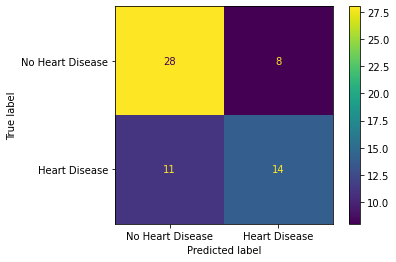

In [44]:
plot_confusion_matrix(knn, x_test, y_test, display_labels=["No Heart Disease", "Heart Disease"])
plt.show()

In [49]:
knn_specificity = 28/(28+11)
knn_sensitivity = 14/(14+8)
print(f"Sensitivity: {knn_sensitivity*100:.2f}%, Specificity: {knn_specificity*100:.2f}%")

Sensitivity: 63.64%, Specificity: 71.79%


In [50]:
logr = LogisticRegression()

In [51]:
logr.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

This error shows us that we have to scale our data for each individual feature to be equally important for the logistic method. So it's easier we will reuse the unsplit dataframe and target and then resplit into training and testing data

In [52]:
from sklearn.preprocessing import scale

In [54]:
scale_features = scale(df2)


In [55]:
scale_x_train, scale_x_test, scale_y_train, scale_y_test = train_test_split(scale_features, target, test_size=0.2)

now we can train the model.

In [56]:
logr.fit(scale_x_train, scale_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We can also look at the model's score

In [57]:
logr_score = logr.score(scale_x_train, scale_y_train)
logr_score

0.8760330578512396

Pretty good. But lets see the testing data.

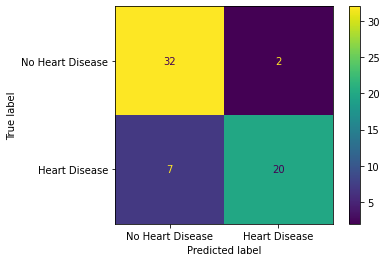

In [58]:
plot_confusion_matrix(logr, scale_x_test, scale_y_test, display_labels=["No Heart Disease", "Heart Disease"])
plt.show()

In [59]:
logr_sensitivity = 20/(20+7)
logr_specificity = 32/(32+2)

Now we can compare the models' specificity and sensitivities.

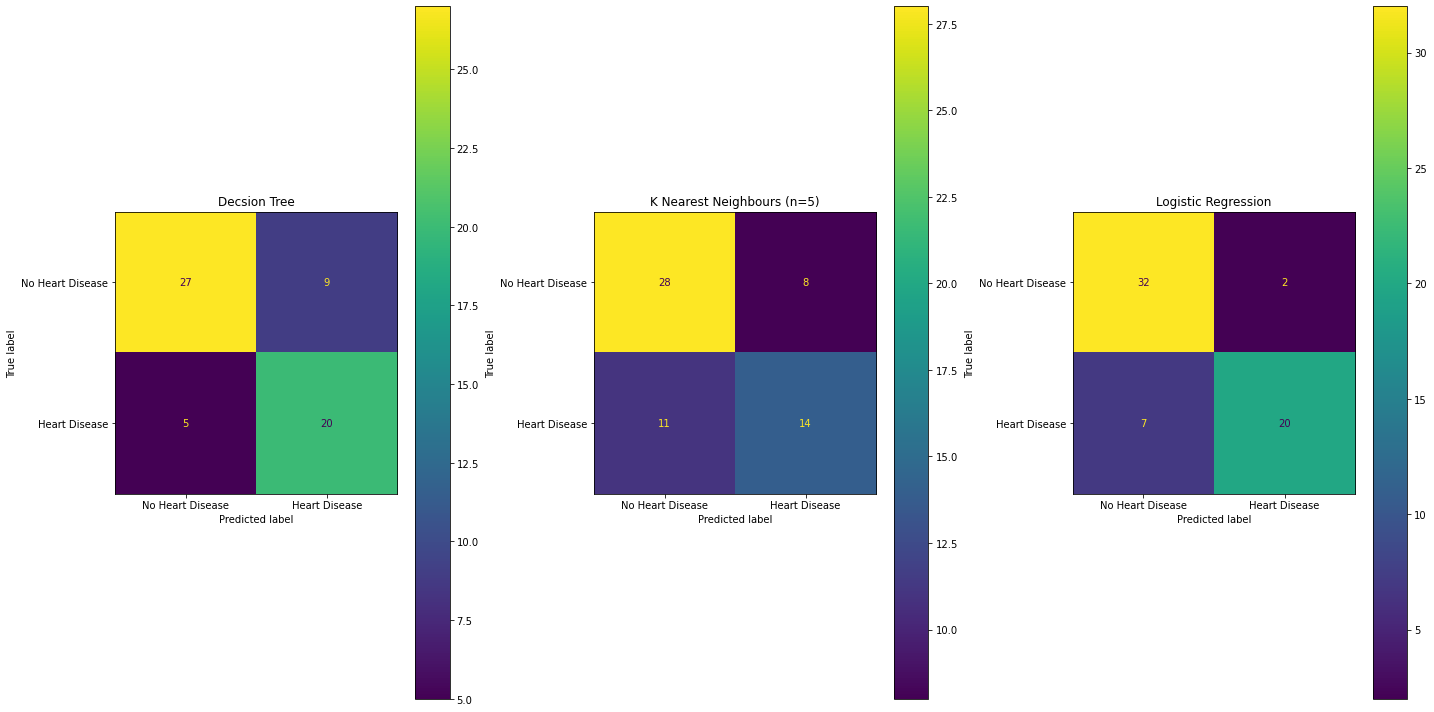

Decision Trees
Sensitivity: 80.00%, Specificity: 75.00%
K Nearest Neighbours
Sensitivity: 63.64%, Specificity: 71.79%
Logistic Regression
Sensitivity: 74.07%, Specificity: 94.12%


In [66]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
plot_confusion_matrix(tree, x_test, y_test, display_labels=["No Heart Disease", "Heart Disease"], ax=axs[0])
plot_confusion_matrix(knn, x_test, y_test, display_labels=["No Heart Disease", "Heart Disease"], ax=axs[1])
plot_confusion_matrix(logr, scale_x_test, scale_y_test, display_labels=["No Heart Disease", "Heart Disease"], ax=axs[2])
axs[0].set_title("Decsion Tree")
axs[1].set_title(f"K Nearest Neighbours (n=5)")
axs[2].set_title("Logistic Regression")
plt.tight_layout()
plt.show()
print("Decision Trees")
print(f"Sensitivity: {tree_sensitivity*100:.2f}%, Specificity: {tree_specificity*100:.2f}%")
print("K Nearest Neighbours")
print(f"Sensitivity: {knn_sensitivity*100:.2f}%, Specificity: {knn_specificity*100:.2f}%")
print("Logistic Regression")
print(f"Sensitivity: {logr_sensitivity*100:.2f}%, Specificity: {logr_specificity*100:.2f}%")



So currently it looks as though, from the simple models we created, that the decision tree is the way to go. Though the averaged results are actually better for Logistic regression in this instance, when we think about the real world application, for us it is more important to be able to classify true positives (sensitivity) then to negate true negatives. This is because for people to continue their normal lives with a false negative of heart disease diagnosis, would potentially be more deadly, then for a person with a false positive diagnosis, although both situations are not optimal.

Next we should look into optimising the decision tree, and/or tuning hyperparamters.